# Определение стоимости автомобилей

Задача данного проекта - выбрать лучшую модель для вычисления рыночной стоимости автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<a name="back_to_content"></a>
### Оглавление
1. [Загрузка данных](#loading)
2. [Подготовка данных](#data_preprocessing)
	* [Анализ количественных признаков](#num_features)
	* [Анализ категориальных признаков](#cat_features)
3. [Обучение моделей](#fit)
	* [Подготовка пайплайна](#pipeline)
	* [Модели Sklearn и LGBM](#sklearn_lgbm)
	* [Модель Catboost](#cat_features)
4. [Анализ моделей](#analysis)
6. [Общий вывод](#general_conclusion)

### Описание данных

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**

*Price* — цена (евро)

<a name="loading"></a>
## Загрузка данных
<font size="2">([к содержанию](#back_to_content))</font> 

In [1]:
import time
import importlib
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

GRS = 88877154 

In [2]:
df = pd.read_csv('./datasets/data.csv', parse_dates=['DateCrawled'])

In [3]:
ProfileReport(df, minimal=True)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Вывод
В данных наблюдаются пропуски в категориальных признаках. Нулевые значения, а также выбросы.

<a name="data_preprocessing"></a>
## Подготовка данных
<a name="num_features"></a>
### Анализ количественных признаков
<font size="2">([к содержанию](#back_to_content))</font>

Сперва избавимся от выбросов, для этого создадим булевый массив, в котором итеративно пометим выбросы в колонках `Price`, `Power` и `Kilometer`.

In [4]:
def get_not_outliers_mask(data, columns, mask=[], low=.5, hi=.95):
    if type(columns)==str:
        columns = [columns]
        
    iqr = data[columns].quantile(0.75) - data[columns].quantile(0.25)
    q_low = data[columns].quantile(low)
    q_hi  = data[columns].quantile(hi)
    
    if len(mask)==0:
        mask = data[columns[0]].notna() #Нужен булевый Series той же длины (не обязательно notna(), но почему бы и не notna())
        
    for c in columns:
        mask = mask & (data[c] <= q_hi.loc[c]) & (data[c] >= q_low.loc[c])
        
    return mask

In [5]:
def show_outliers(columns, mask, separate=False):
    plt.figure(figsize=(18,7))
    sns.set_theme(style="whitegrid")
    
    sns.violinplot(x=df[columns], color='orange', label="original")
    

    if separate:
        plt.show()
        plt.figure(figsize=(18,7))
    
    sns.violinplot(df[mask][columns], color='green', label="sample")
    plt.show()

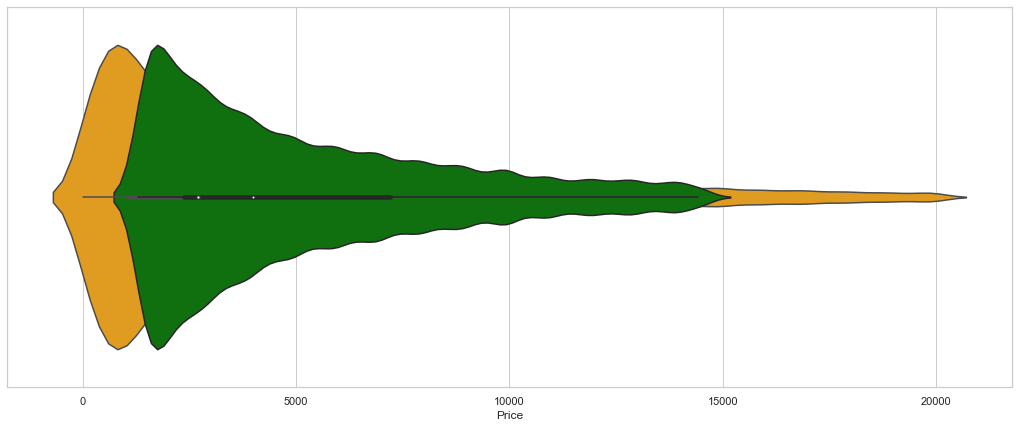

In [6]:
not_outliers_mask = get_not_outliers_mask(df, ['Price'], [], .3)

show_outliers('Price', not_outliers_mask)

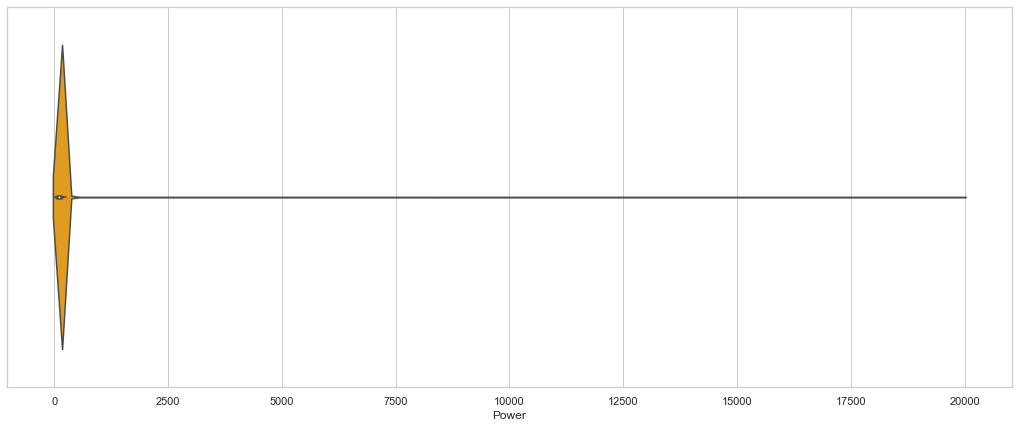

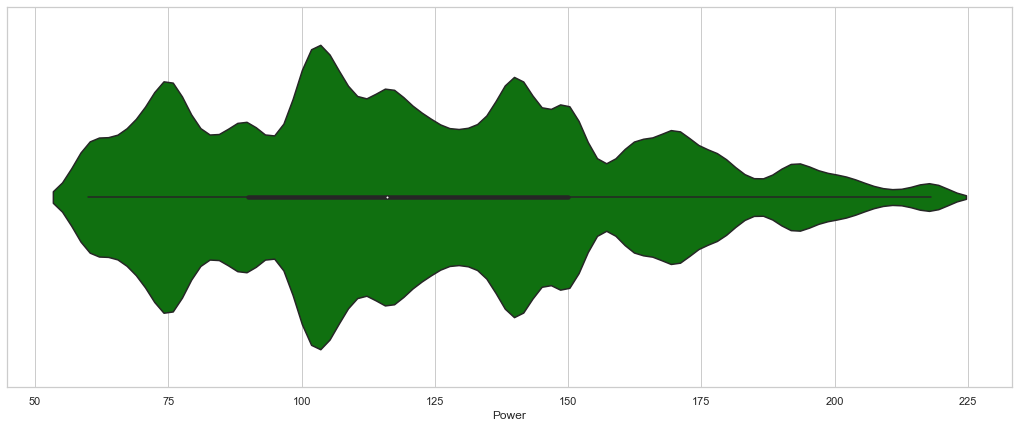

In [7]:
not_outliers_mask = get_not_outliers_mask(df, ['Power'], not_outliers_mask, .2)

show_outliers('Power', not_outliers_mask, True)

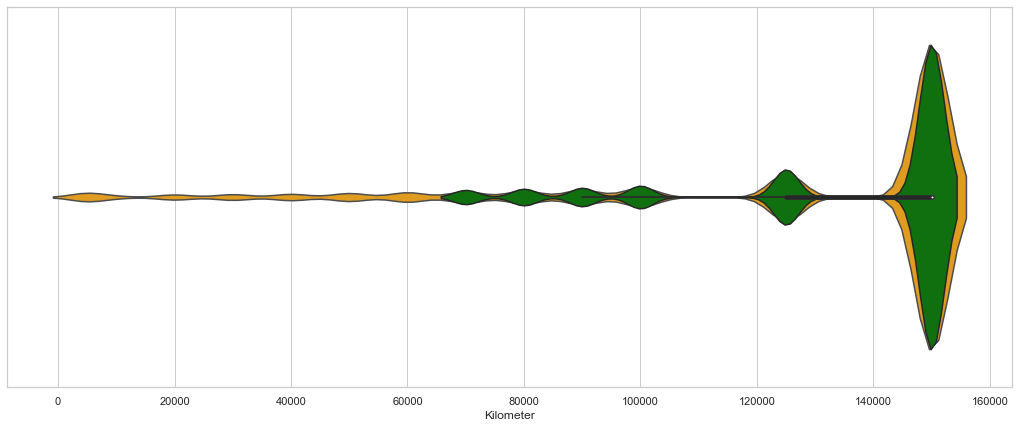

In [8]:
not_outliers_mask = get_not_outliers_mask(df, ['Kilometer'], not_outliers_mask, .1)

show_outliers('Kilometer', not_outliers_mask)

Теперь проанализируем данные по времени использования автомобилем. Проверим период сбора данных. 

In [9]:
print(f"Информация по автомобилям собиралась с {df['DateCrawled'].min()} по {df['DateCrawled'].max()}")

Информация по автомобилям собиралась с 2016-03-05 14:06:22 по 2016-04-07 14:36:58


К сожалению у нас есть данные только о дате регистрации автомобиля. Если автомобиль перепродавали и новый владелец регистрировал его, то "время использования" сбрасывается. Но даже учитывая это, можно получить хоть какую-то информацию по этим датам. Вычтем из года сбора информации (2016) год регистрации.

In [10]:
df['years_since_registration'] = 2016 - df['RegistrationYear']
df['years_since_registration'].describe()

count    354369.000000
mean         11.765552
std          90.227958
min       -7983.000000
25%           8.000000
50%          13.000000
75%          17.000000
max        1016.000000
Name: years_since_registration, dtype: float64

In [11]:
df[df['RegistrationYear'] > 2016].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,years_since_registration
338541,2016-04-02 10:06:24,6800,NaN,2017,auto,205,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-04-02 00:00:00,0,65428,2016-04-05 17:26:21,-1
154637,2016-03-31 09:51:38,1200,NaN,2017,manual,70,getz,150000,7,NaN,hyundai,no,2016-03-31 00:00:00,0,54294,2016-04-04 02:15:24,-1
326025,2016-03-11 17:56:35,1150,NaN,2017,manual,0,other,150000,6,petrol,suzuki,no,2016-03-11 00:00:00,0,23701,2016-03-12 22:45:47,-1
68697,2016-03-16 23:57:39,0,NaN,2017,manual,116,golf,150000,6,NaN,volkswagen,NaN,2016-03-16 00:00:00,0,16515,2016-03-17 05:37:57,-1
161916,2016-03-31 09:50:33,3250,NaN,2018,manual,101,3er,150000,2,NaN,bmw,NaN,2016-03-31 00:00:00,0,26384,2016-04-02 05:16:10,-2


В данных обнаружены автомобили, у которых указанный **год регистрации больше чем год сбора информации**. Отметим такие строки как выбросы. 

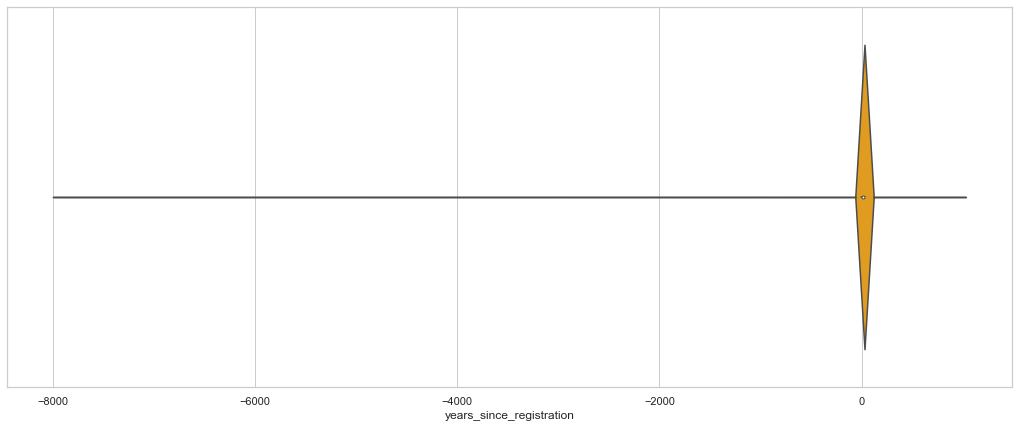

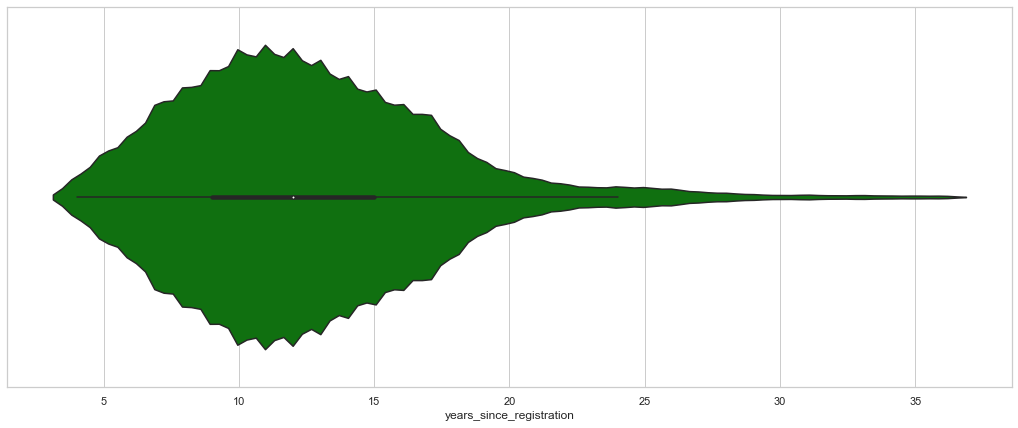

In [12]:
not_outliers_mask = get_not_outliers_mask(df, ['years_since_registration'], not_outliers_mask, .1, .99)

show_outliers('years_since_registration', not_outliers_mask, True)

<a name="cat_features"></a>
### Анализ категориальных признаков
<font size="2">([к содержанию](#back_to_content))</font>

In [13]:
df['Brand'].isna().sum()

0

In [14]:
brand_model = df.groupby(['Brand','Model'], dropna=False)['Model'].count()
print('Количесво уникальных брендов:', len(df['Brand'].unique()),'Количесво уникальных моделей:', len(df['Model'].unique()))

print('Количество групп при объединении:', len(brand_model))

Количесво уникальных брендов: 40 Количесво уникальных моделей: 251
Количество групп при объединении: 337


Среди брендов есть повторяющиеся модели, чтобы четко категоризировать автомобили друг от друга, можно слить эти 2 колонки в одну. Тогда каждая модель будет уникальной, благодаря префиксу бренда. Пропусков в брендах не обнаружено, а в моделях их можно заполнить самой популярной моделью в бренде, однако лучшем вариантом подобного вида пропуск оставить отдельной группой. Таким образом модель будет работать с отсутствием информации как с отдельной категорией. 

In [15]:
df['Model'] = df['Model'].fillna('notSpecified')
df['brand_model'] = df['Brand'].values + '_' + df['Model'].values
df['brand_model'].value_counts()

volkswagen_golf                  29232
bmw_3er                          19761
volkswagen_polo                  13066
opel_corsa                       12570
opel_astra                       10809
                                 ...  
rover_freelander                     3
rover_discovery                      2
land_rover_serie_1                   2
land_rover_range_rover_evoque        2
rover_defender                       1
Name: brand_model, Length: 337, dtype: int64

In [16]:
list(df)

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen',
 'years_since_registration',
 'brand_model']

Сохраним списки категориальных и количественных переменных. А также укажем какие колонки нам не понадобятся для обучения моделей. Остальную предобработку поручим модулю Pipeline.

In [17]:
drop_column=[
    'DateCrawled',
    'RegistrationYear',
    'RegistrationMonth',
    'DateCreated',
    'PostalCode',
    'LastSeen',
    'NumberOfPictures',

     'Model',
     'Brand'
 ]

catFeatures = [
    'VehicleType',
    'Gearbox',
    'FuelType',
    'NotRepaired',
    'brand_model'
]

numFeatures = list(set(df) - set(catFeatures) - set(['Price']) - set(drop_column))
numFeatures

['Kilometer', 'Power', 'years_since_registration']

In [18]:
ProfileReport(df[not_outliers_mask].drop(drop_column, axis=1), minimal=True)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
def get_train_valid(data, target, random_state, drop_column=[], size=.25):
    '''
    data : DataFrame cо всеми признаками.
    target : название колонки с целевым признаком.
    size : доля валедационной выборки.
    drop_column : колонки которые необходимо удалить.
    
    return (features_train, features_valid, target_train, target_valid)
    '''
    
    data = data.drop(drop_column,axis=1)
            
    features_train, features_valid, target_train, target_valid = train_test_split(
        data.drop([target],axis=1),
        data[target],
        test_size=size,
        random_state=random_state
    )
    return (
        features_train,
        features_valid,
        target_train,
        target_valid
    )

Применим к общему датасету нашу маску выбросов, удалим лишние колонки и разделем датасет на валидационную и обучающую выборку. 

In [20]:
X_train, X_valid, y_train, y_valid = get_train_valid(df[not_outliers_mask].fillna('null'), 'Price', GRS, drop_column)

<a name="fit"></a>
## Обучение моделей
<font size="2">([к содержанию](#back_to_content))</font>

Напишем функции для массовой проверки моделей.

In [21]:
def get_best_model(
    model,
    preprocessor,
    features_train,
    target_train,
    hyperparameters,
    target_score=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    n_jobs=-1,
    verbose=True
):
    '''
    Обучает модель несколько раз с переданными гиперпараметрами и возвращает лучшую.
    
    model : Объект модели.
    preprocessor : препроцессор, который будет объединен с моделью в пайплайн.
    hyperparameters : словарь гиберпараметров для GridSearchCV.
    
    return (best_model, best_params, mean_fit_time)
    '''    
    
    prefix = ''
    
    if preprocessor != False:
        prefix = 'model__'
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
             
    grid = GridSearchCV(
        model,
        {prefix+key:value for key, value in hyperparameters.items()},
        scoring=target_score,
        cv=cv, n_jobs=n_jobs, verbose=verbose).fit(features_train, target_train)


    return (grid.best_estimator_, grid.best_params_, grid.cv_results_['mean_fit_time'])

In [22]:
def fit_multiple_models(
    features_train,
    features_valid,
    target_train,
    target_valid,
    model_list,
    target_score=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    cv=5,
    n_jobs=-1,
    verbose=True):
    '''
    Обучает список моделей, подюерая для каждой оптимальные гиперпараметры.
    
    model_list : список моделей формата [(label, model, preprocessor_label, preprocessor, hyperparameters), ...]
        label : str, краткое описание модели.
        model : Объект модели.
        preprocessor_label : str, краткое описание прероцессора.
        preprocessor : препроцессор, который будет объединен с моделью в пайплайн.
        hyperparameters : словарь гиберпараметров для GridSearchCV.
        
        Допускается передать в model_list, DataFrame.
    
    return pd.DataFrame(list, columns=['model_obj', 'label', 'preprocessor_label', 'sample', 'best_hp', 'fit_time_at_1e6', 'pred_time_at_1e6', 'rmse'])
    '''
    
    
    result = []
    for label, model, preprocessor_label, preprocessor, hyperparameters in (model_list.values if type(model_list) is pd.DataFrame else model_list):
        print(f'███\tFit {label}')

        best_model, best_params, mean_fit_time = get_best_model(model, preprocessor, features_train, target_train,
                                                 hyperparameters,# random_state,
                                                 target_score=target_score,
                                                 cv=cv, n_jobs=n_jobs, verbose=verbose)            
        time_start = time.time()    
        predict = best_model.predict(features_valid)
        pred_time = time.time() - time_start

        result.append([
            best_model,
            label,
            preprocessor_label,
            best_params,
            (mean_fit_time.mean() * 100000 / len(features_train)).round(4),     
            round((pred_time * 100000 / len(features_valid)),4),
            mean_squared_error(target_valid, predict, squared=False)
        ])
            
        
    return pd.DataFrame(result, columns=['model_obj', 'label', 'preprocessor_label', 'best_hp', 'fit_time_at_1e6', 'pred_time_at_1e6', 'rmse'])

Опишем последовательность предобработки для Pipeline. А также список исследуемых моделей. В качесьве метода корирования ктегориальных признаков иследуем `OneHotEncoder` и `OrdinalEncoder`.

<a name="pipeline"></a>
### Подготовка пайплайна
<font size="2">([к содержанию](#back_to_content))</font>

In [23]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer_ohe = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_transformer_ordinal = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=325))
])

cat_transformer_ordinal_ss = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=325)),
    ('scaler', StandardScaler())
])




preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer_ohe, catFeatures)
    ])

preprocessor_ohe_ss = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numFeatures),
        ('cat', cat_transformer_ohe, catFeatures)
    ])

preprocessor_ordinal = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer_ordinal, catFeatures)
    ])

preprocessor_ordinal_ss = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer_ordinal_ss, catFeatures),
        ('num', num_transformer, numFeatures)
    ])

<a name="sklearn_lgbm"></a>
### Модели Sklearn и LGBM
<font size="2">([к содержанию](#back_to_content))</font>

In [24]:
MODELS = pd.DataFrame([    
    ['DummyRegressor', DummyRegressor(), 'null', False, {"strategy": ['mean', 'median']}],
    
    ['LGBM', LGBMRegressor(metric='rmse', random_state=GRS), 'OHE', preprocessor_ohe, {'learning_rate': np.linspace(0.3, 0.6, 4), "max_depth": range(15, 60, 15)}],
    ['DecisionTreeRegressor', DecisionTreeRegressor(random_state=GRS), 'OHE', preprocessor_ohe, {"max_depth": range(1, 100, 10)}],
    ['Ridge', Ridge(random_state=GRS), 'OHE', preprocessor_ohe, {'alpha': np.linspace(0, 1, 6)}],
    
    ['LGBM', LGBMRegressor(metric='rmse', random_state=GRS), 'Ordinal', preprocessor_ordinal, {'learning_rate': np.linspace(0.3, 0.6, 4), "max_depth": range(15, 60, 15)}],
    ['DecisionTreeRegressor', DecisionTreeRegressor(random_state=GRS), 'Ordinal', preprocessor_ordinal, {"max_depth": range(1, 100, 10)}],
    ['Ridge', Ridge(random_state=GRS), 'Ordinal', preprocessor_ordinal, {'alpha': np.linspace(0, 1, 6)}],
    
    ['LGBM', LGBMRegressor(metric='rmse', random_state=GRS), 'OHE + Scaler', preprocessor_ohe_ss, {'learning_rate': np.linspace(0.3, 0.6, 4), "max_depth": range(15, 60, 15)}],
    ['DecisionTreeRegressor', DecisionTreeRegressor(random_state=GRS), 'OHE + Scaler', preprocessor_ohe_ss, {"max_depth": range(1, 100, 10)}],
    ['Ridge', Ridge(random_state=GRS), 'OHE + Scaler', preprocessor_ohe_ss, {'alpha': np.linspace(0, 1, 6)}],
    
    ['LGBM', LGBMRegressor(metric='rmse', random_state=GRS), 'Ordinal + Scaler', preprocessor_ordinal_ss, {'learning_rate': np.linspace(0.3, 0.6, 4), "max_depth": range(15, 60, 15)}],
    ['DecisionTreeRegressor', DecisionTreeRegressor(random_state=GRS), 'Ordinal + Scaler', preprocessor_ordinal_ss, {"max_depth": range(1, 100, 10)}],
    ['Ridge', Ridge(random_state=GRS), 'Ordinal + Scaler', preprocessor_ordinal_ss, {'alpha': np.linspace(0, 1, 6)}],    
],
columns=['label', 'model', 'preprocessor_label', 'preprocessor', 'hyperparameters'])
display(MODELS)

,label,model,preprocessor_label,preprocessor,hyperparameters
0,DummyRegressor,DummyRegressor(),null,False,"{'strategy': ['mean', 'median']}"
1,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
2,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
3,Ridge,Ridge(random_state=88877154),OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."
4,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
5,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
6,Ridge,Ridge(random_state=88877154),Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."
7,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
8,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
9,Ridge,Ridge(random_state=88877154),OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."


In [26]:
%%time
models1 = fit_multiple_models(
    X_train,
    X_valid,
    y_train,
    y_valid,
    
    MODELS,
    )
display(MODELS)
[x for x in models1['best_hp'].values]

███	Fit DummyRegressor
Fitting 5 folds for each of 2 candidates, totalling 10 fits
███	Fit LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
███	Fit DecisionTreeRegressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
███	Fit Ridge
Fitting 5 folds for each of 6 candidates, totalling 30 fits
███	Fit LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
███	Fit DecisionTreeRegressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
███	Fit Ridge
Fitting 5 folds for each of 6 candidates, totalling 30 fits
███	Fit LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
███	Fit DecisionTreeRegressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
███	Fit Ridge
Fitting 5 folds for each of 6 candidates, totalling 30 fits
███	Fit LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
███	Fit DecisionTreeRegressor
Fitting 5 folds for each of 10 candidates, totalling 50 fits
███	Fit Ridge
Fitting 5 folds for e

,label,model,preprocessor_label,preprocessor,hyperparameters
0,DummyRegressor,DummyRegressor(),null,False,"{'strategy': ['mean', 'median']}"
1,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
2,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
3,Ridge,Ridge(random_state=88877154),OHE,"ColumnTransformer(transformers=[('cat',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."
4,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
5,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
6,Ridge,Ridge(random_state=88877154),Ordinal,"ColumnTransformer(transformers=[('cat',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."
7,LGBM,"LGBMRegressor(metric='rmse', random_state=8887...",OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'learning_rate': [0.3, 0.39999999999999997, 0..."
8,DecisionTreeRegressor,DecisionTreeRegressor(random_state=88877154),OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'max_depth': (1, 11, 21, 31, 41, 51, 61, 71, ..."
9,Ridge,Ridge(random_state=88877154),OHE + Scaler,"ColumnTransformer(transformers=[('num',\n ...","{'alpha': [0.0, 0.2, 0.4, 0.6000000000000001, ..."


Wall time: 3min 44s


[{'strategy': 'mean'},
 {'model__learning_rate': 0.6, 'model__max_depth': 30},
 {'model__max_depth': 91},
 {'model__alpha': 1.0},
 {'model__learning_rate': 0.5, 'model__max_depth': 15},
 {'model__max_depth': 41},
 {'model__alpha': 1.0},
 {'model__learning_rate': 0.5, 'model__max_depth': 15},
 {'model__max_depth': 21},
 {'model__alpha': 0.6000000000000001},
 {'model__learning_rate': 0.39999999999999997, 'model__max_depth': 30},
 {'model__max_depth': 11},
 {'model__alpha': 1.0}]

<a name="catboost"></a>
### Модель Catboost
<font size="2">([к содержанию](#back_to_content))</font>

Помимо моделей sklearn и LGBM обучим Catboost c дефолтными параметрами.

In [27]:
def catboost_interface(
    features_train,
    features_valid,
    target_train,
    target_valid,
    cat_features,
    scorer,
    random_state,
    preprocessor_label='',
    scorer_arg={}
):
    cat_boost = CatBoostRegressor(random_seed=random_state, verbose=200)
    time_start = time.time()
    cat_boost.fit(features_train.fillna('nan'), target_train, cat_features=cat_features)
    fit_time = time.time() - time_start
    
    time_start = time.time()    
    pred = cat_boost.predict(features_valid.fillna('nan'))
    pred_time = time.time() - time_start
    
    result = [[
        cat_boost,
        'CatBoostRegressor',
        preprocessor_label,
        {},#best_params,
        round((fit_time * 100000 / len(features_train)),4),        
        round((pred_time * 100000 / len(features_valid)),4),
        scorer(target_valid, pred, **scorer_arg)
    ]]
    
    return pd.DataFrame(result, columns=['model_obj','label','preprocessor_label','best_hp', 'fit_time_at_1e6', 'pred_time_at_1e6', 'rmse'])

In [28]:
models2 = catboost_interface(
    X_train, X_valid, y_train, y_valid,
    catFeatures,
    mean_squared_error,
    GRS,
    'null',
    scorer_arg={'squared': False}
)
models2

Learning rate set to 0.092153
0:	learn: 3014.9666163	total: 226ms	remaining: 3m 45s
200:	learn: 1397.5352020	total: 12.8s	remaining: 50.7s
400:	learn: 1354.2523078	total: 24.9s	remaining: 37.3s
600:	learn: 1329.5482666	total: 37.2s	remaining: 24.7s
800:	learn: 1312.9667786	total: 49.5s	remaining: 12.3s
999:	learn: 1299.3311084	total: 1m 2s	remaining: 0us


,model_obj,label,preprocessor_label,best_hp,fit_time_at_1e6,pred_time_at_1e6,rmse
0,<catboost.core.CatBoostRegressor object at 0x0...,CatBoostRegressor,null,{},50.4657,0.2549,1332.147987


Объединим модели и сохраним их на диск.

In [29]:
models = pd.concat([models1, models2])
with open('models.pickle', 'wb') as f:
    pickle.dump(models, f)

### Вывод
Модели обучены, метрики собраны, мы готовы к анализу.

<a name="analysis"></a>
## Анализ моделей
<font size="2">([к содержанию](#back_to_content))</font>

Сравним метрики RMSE и скорости обучения и предсказания моделей.

In [30]:
def highlight_min(data, color='red'):
    attr = 'font-weight: 1000; color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.min()
        return [attr if v else '' for v in is_max]
    else:
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [31]:
def show_models(models, score, title):
    display(models.pivot_table(values=score, index=['label', 'preprocessor_label']).
            style.format('{:.3f}').
            apply(highlight_min, color='#7573D9', axis=0).
            bar(color='#FFD040'))
    
    if not type(score) is list:
        score = [score]
    
    sns.set(font_scale=1.8, style="whitegrid")
    
    if len(models['preprocessor_label'].unique()) == 1:
        plt.rcParams['figure.figsize']=(17,8)
        for i in range(len(score)):
            sns.barplot(
                data=models,
                y='label',
                x=score[i]
            ).set_title(title[i])

            plt.tight_layout()
            plt.show()
    else:
        plt.rcParams['figure.figsize']=(20,10)
        for i in range(len(score)):
            sns.lineplot(
                data=models,
                x='preprocessor_label',
                y=score[i],
                hue='label',
                style='label',
                dashes=False,
                marker="o",
                
                markersize=9,
                linewidth = 4
            ).set_title(title[i])
            plt.xticks(rotation=30)

            plt.tight_layout()
            plt.show()

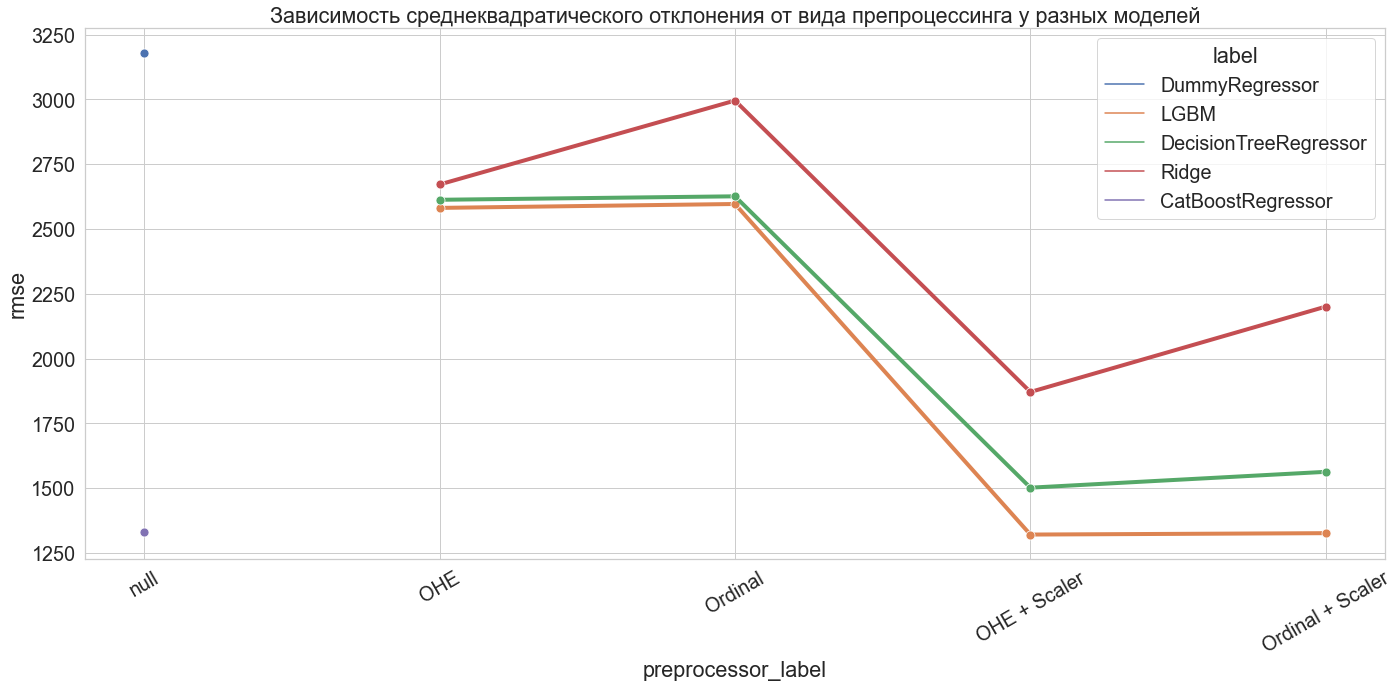

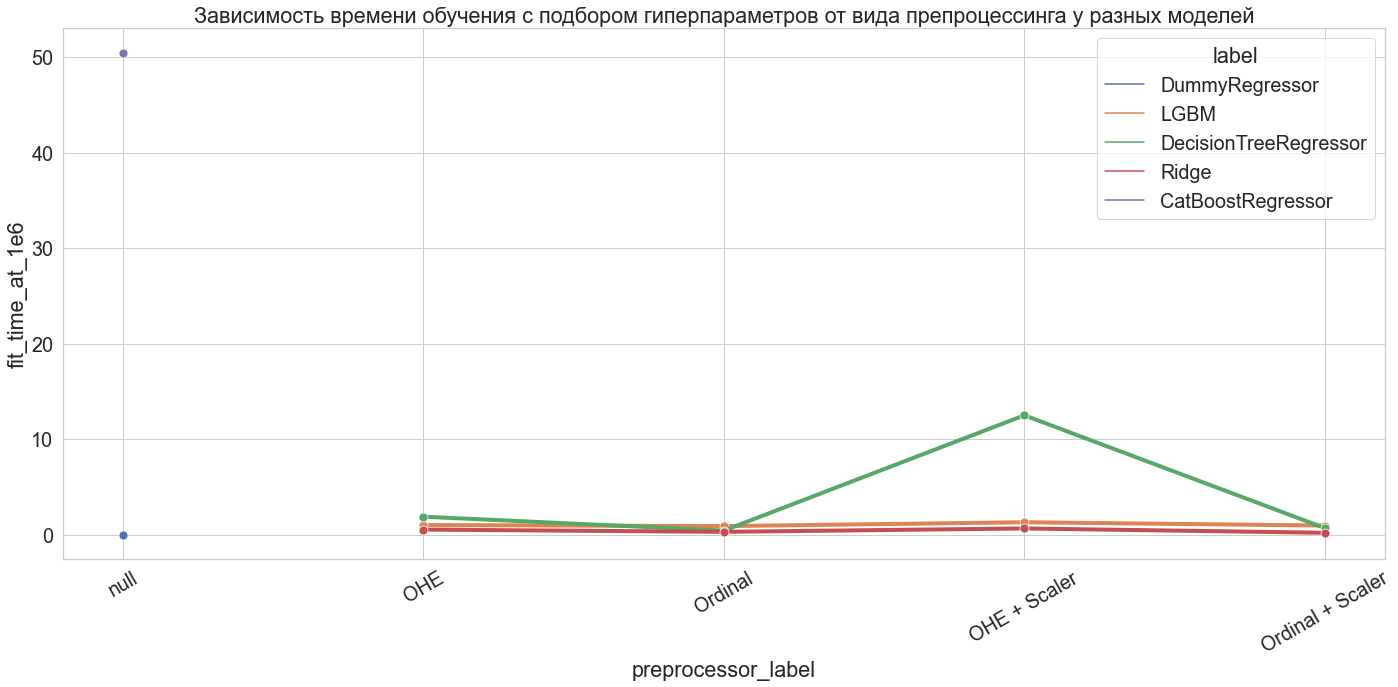

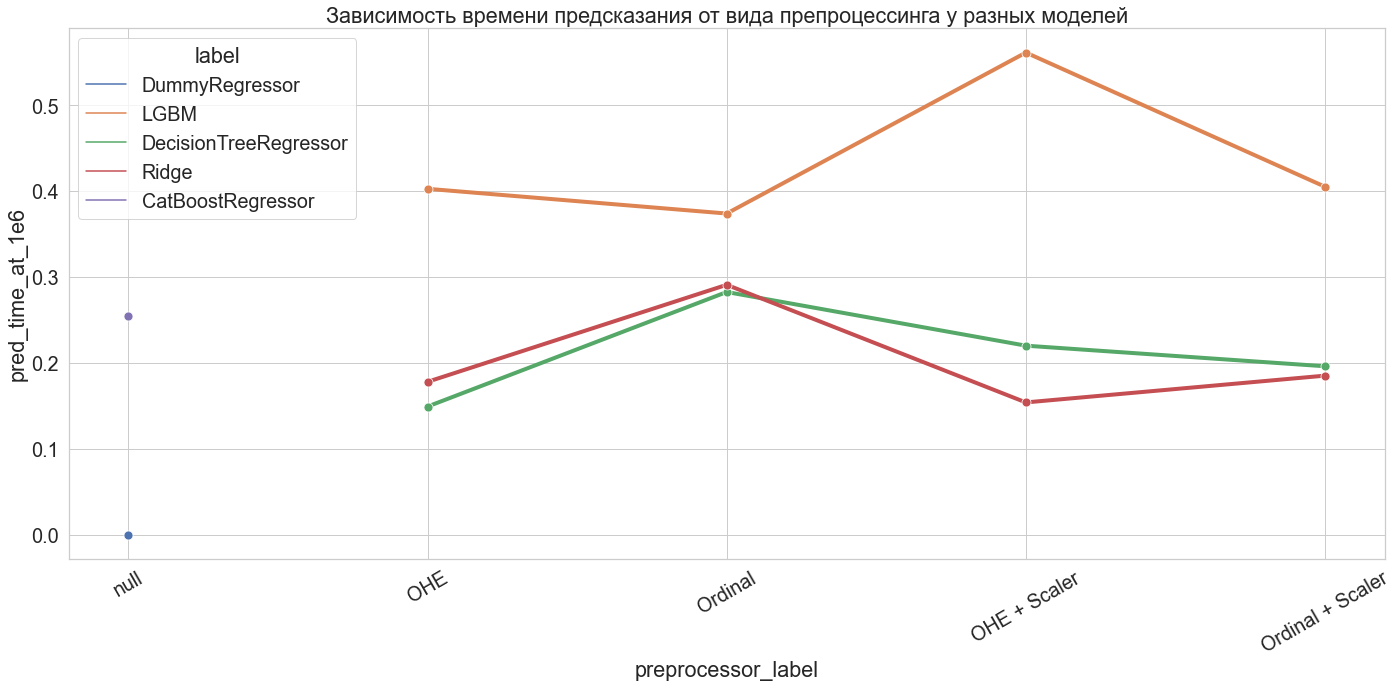

In [32]:
show_models(models, ['rmse',
                     'fit_time_at_1e6',
                     'pred_time_at_1e6'], 
            ['Зависимость среднеквадратического отклонения от вида препроцессинга у разных моделей',
             'Зависимость времени обучения с подбором гиперпараметров от вида препроцессинга у разных моделей',
             'Зависимость времени предсказания от вида препроцессинга у разных моделей'])

<a name="general_conclusion"></a>
## Общий вывод
<font size="2">([к содержанию](#back_to_content))</font>

Лучшими моделями, исходя из **метрики RMSE**, можно назвать LightGBM и CatBoost. Все они имеют значение ошибки примерно в 1330 евро. На втором месте DecisionTree, с метрикой в 1500.

Среди них **обучается быстрее всего** LightGBM и DecisionTree. **Наименьшая скорость обучения** у CatBoostRegressor, в разы больше чем у остальных моделей. Из них самой быстрой можно считать DecisionTree, но так как ошибка у нее больше, лучшем решением для данной задачи будет **LightGBM**.

Метод Ordinal Encoder и One-Hot Encoding, при масштабировании переменных дают примерно одинаковый результат RMSE для каждой модели. Исключение - модель Ridge, для нее лучше работает  Ordinal Encoder.